<a href="https://colab.research.google.com/github/poojasaxena/tensorflow-developer-zertificate-coursera/blob/main/course2_convolutional-neural-networks-tensorflow/03_transfer-learning/Course_2_Part_6_Lesson_3_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [21]:
if os.path.isfile('/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'):
  print('>>>>>>> inception_v3_weights file exist', os.listdir('/tmp'))
else:
  print('>>>>>> Uploading inception h5 file in /tmp ============================')
  !wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
  -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
 

>>>>>>> inception_v3_weights file exist ['inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5', 'dap_multiplexer.f5058b7314c5.root.log.INFO.20210310-072547.48', 'debugger_96wpwb0cp', 'initgoogle_syslog_dir.0', 'dap_multiplexer.INFO']


In [22]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), #needed if include_top:False, E.g: (150,150,3)
                                include_top = False,  #include_top: Boolean, if include the fully-connected layer at the top, as the last layer of the network. Default to `True`.
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [24]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])


In [28]:
! ls /tmp/

cats_and_dogs_filtered.zip
dap_multiplexer.f5058b7314c5.root.log.INFO.20210310-072547.48
dap_multiplexer.INFO
debugger_96wpwb0cp
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
initgoogle_syslog_dir.0


In [29]:
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## upload cats_vs_dogs dataset
local_zip = '/tmp/cats_and_dogs_filtered.zip'

if os.path.isfile('/tmp/cats_and_dogs_filtered'):
  print('>>>>>>>>>>>>>>> Dataset exist:', os.listdir('/tmp'))
else:
  print('>>>>>>>>>>>>>> Uploading dataset========') 
  !wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /tmp/cats_and_dogs_filtered.zip
  zip_ref = zipfile.ZipFile(local_zip, 'r')
  zip_ref.extractall('/tmp')
  zip_ref.close()


# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

>>>>>>>>>>>>>> Uploading dataset========
--2021-03-10 08:19:04--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.122.128, 172.217.13.240, 172.253.63.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.122.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   149MB/s    in 0.4s    

2021-03-10 08:19:04 (149 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [30]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100, ## 2000 = steps_per_epoch * epochs
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 53s - loss: 0.3683 - accuracy: 0.8510 - val_loss: 0.1080 - val_accuracy: 0.9610
Epoch 2/20
100/100 - 18s - loss: 0.2172 - accuracy: 0.9215 - val_loss: 0.1738 - val_accuracy: 0.9420
Epoch 3/20
100/100 - 18s - loss: 0.2132 - accuracy: 0.9175 - val_loss: 0.1124 - val_accuracy: 0.9610
Epoch 4/20
100/100 - 18s - loss: 0.1846 - accuracy: 0.9305 - val_loss: 0.1741 - val_accuracy: 0.9510
Epoch 5/20
100/100 - 18s - loss: 0.1624 - accuracy: 0.9390 - val_loss: 0.1072 - val_accuracy: 0.9670
Epoch 6/20
100/100 - 18s - loss: 0.1626 - accuracy: 0.9435 - val_loss: 0.1049 - val_accuracy: 0.9690
Epoch 7/20
100/100 - 18s - loss: 0.1908 - accuracy: 0.9340 - val_loss: 0.1001 - val_accuracy: 0.9680
Epoch 8/20
100/100 - 18s - loss: 0.1635 - accuracy: 0.9385 - val_loss: 0.1219 - val_accuracy: 0.9680
Epoch 9/20
100/100 - 18s - loss: 0.1639 - accuracy: 0.9395 - val_loss: 0.1137 - val_accuracy: 0.9670
Epoch 10/20
100/100 - 18s - loss: 0.1561 - accuracy: 0.9480 - val_loss: 0.1302 - val_accura

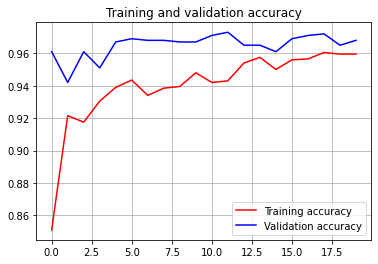

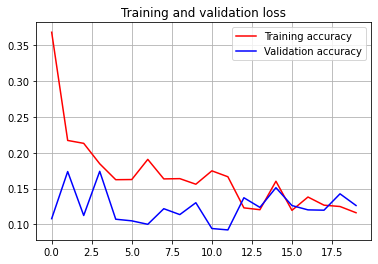

<Figure size 432x288 with 0 Axes>

In [34]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.grid(True)
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training accuracy')
plt.plot(epochs, val_loss, 'b', label='Validation accuracy')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.grid(True)
plt.figure()


plt.show()